In [75]:
import numpy as np
import pandas as pd
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils import SkyCircularAperture, aperture_photometry
import astropy.units as u
from astropy.coordinates import SkyCoord


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_93664/986476987.py:6: DeprecationWarning: `photutils.SkyCircularAperture` is a deprecated alias for `photutils.aperture.SkyCircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import SkyCircularAperture` to silence this warning.
  from photutils import SkyCircularAperture, aperture_photometry
/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_93664/986476987.py:6: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import SkyCircularAperture, aperture_photometry


In [32]:
goodss_result = pd.read_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/catalog_n/xandyadded_goodsslast.csv')

In [72]:
def load_image(galaxy_id, band):
    # the base path where the FITS files 
    base_path = '/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts_galaxies'
    
    # Construct the filename using the galaxy ID and band
    file_name = f'{base_path}/goodss_{galaxy_id}_{band}_images.fits'
    
    # Open the FITS file and return the image data
    with fits.open(file_name) as hdul:
        image_data = hdul[0].data
    
    return image_data

In [73]:
# # Loop over the catalog
# for index, row in goodss_result.iterrows():
#     if row['Clump_ID'] != -99:  # Ensure this is an actual detected clump
        
#         # Map redshift to band directly
#         if 0.5 <= row['z'] < 1:
#             band = 'f275w'
#         elif 1 <= row['z'] < 2:
#             band = 'f435w'
#         elif 2 <= row['z'] <= 3:
#             band = 'f606w'
#         else:
#             raise ValueError("Redshift out of bounds for band selection")
        
#         image_data = load_image(row['CANDELS_ID'], band)
# Define a function to get the appropriate band based on redshift
def get_band_from_redshift(z):
    if 0.5 <= z < 1:
        return 'f275w'
    elif 1 <= z < 2:
        return 'f435w'
    elif 2 <= z <= 3:
        return 'f606w'
    else:
        raise ValueError("Redshift out of bounds for band selection")

In [35]:
def apply_mask(image, clump_positions, current_index, mask_radius=3):
    mask = np.ones_like(image, dtype=bool)
    for i, pos in enumerate(clump_positions):
        if i != current_index:
            x, y = pos
            mask[max(0, y - mask_radius):min(image.shape[0], y + mask_radius + 1),
                 max(0, x - mask_radius):min(image.shape[1], x + mask_radius + 1)] = False
    return image * mask

In [70]:
def mask_other_clumps(image, clump_positions, wcs, mask_radius):
    masked_image = np.copy(image)  # Copy the image to not alter the original
    
    for clump_pos in clump_positions:
        # Convert clump position to SkyCoord object
        clump_coord = SkyCoord(ra=clump_pos[0] * u.deg, dec=clump_pos[1] * u.deg)
        
        # Create circular aperture and corresponding mask for this clump
        aperture = SkyCircularAperture(clump_coord, r=mask_radius * u.arcsec)
        mask = aperture.to_pixel(wcs).to_mask(method='center')
        
        # Apply the mask to the image
        image_cutout = mask.apply(masked_image, fill_value=0)
        
        # Update the masked_image
        slices = mask.bbox.slices
        masked_image[slices] = image_cutout
        
    return masked_image


In [48]:
# def centroid(im, region=None):
#     """Compute centroid of image or region (M10/M00, M01/M00) (x, y)."""
#     if region is not None:
#         im = im[region[0]:region[1], region[2]:region[3]]
#         offset = [region[2], region[0]]
#     else: 
#         offset = [0, 0]
#     m00 = np.sum(im)
#     m10 = np.sum(np.sum(im, axis=1) * np.arange(im.shape[0]))
#     m01 = np.sum(np.sum(im, axis=0) * np.arange(im.shape[1]))
#     return [m10 / m00 + offset[0], m01 / m00 + offset[1]]
def centroid(im, region=None):
    """Compute centroid of image or region (M10/M00, M01/M00) (x, y)."""
    if region is not None:
        im = im[region[0]:region[1], region[2]:region[3]]
        offset = [region[2], region[0]]
    else: 
        offset = [0, 0]
    m00 = np.sum(im)
    m10 = np.sum(np.sum(im, axis=1) * np.arange(im.shape[0]))  # Check axis order
    m01 = np.sum(np.sum(im, axis=0) * np.arange(im.shape[1]))
    print(f"m00: {m00}, m10: {m10}, m01: {m01}")  # Debug outputs
    if m00 == 0:
        return [np.nan, np.nan]
    return [m10 / m00 + offset[0], m01 / m00 + offset[1]]



In [37]:
mask_radius = 3

In [38]:
goodss_result['new_X_centroid'] = np.nan
goodss_result['new_Y_centroid'] = np.nan


In [76]:
# Assuming your DataFrame has 'X_clump' and 'Y_clump' columns with initial clump positions

for index, row in goodss_result.iterrows():
    if row['Clump_ID'] != -99:  # Exclude entries without a detected clump
        # Get the appropriate band based on redshift
        band = get_band_from_redshift(row['z'])
        
        # Load the image data for the current clump
        image_data = load_image(row['CANDELS_ID'], band)
        print(f"Image data shape: {image_data.shape}, max value: {np.max(image_data)}, min value: {np.min(image_data)}")

        # Get all clump positions for the current galaxy (excluding the current clump)
        # converting the clump positions to integers for the purpose of slicing the image array doesn't change their actual positions; it is a necessary step for indexing arrays which requires integer indices. 
        # clump_positions = [(int(x), int(y)) for idx, (x, y) in enumerate(zip(goodss_result['X_clump'], goodss_result['Y_clump'])) if idx != index]
        # print(f"Clump positions (excluding current): {clump_positions}")

        # Convert RA and DEC to SkyCoord object, ensuring they are in degrees
        ra_dec_positions = [(ra, dec) for ra, dec in zip(goodss_result['RA_clump'], goodss_result['DEC_clump'])]
        sky_positions = [SkyCoord(ra=ra*u.deg, dec=dec*u.deg) for ra, dec in ra_dec_positions if not np.isnan(ra) and not np.isnan(dec)]
        
        # # Apply the mask to the image data
        masked_image = mask_other_clumps(image_data, clump_positions, index, mask_radius=3)

        y_min = max(0, int(row['Y_clump']) - mask_radius)
        y_max = min(image_data.shape[0], int(row['Y_clump']) + mask_radius)
        x_min = max(0, int(row['X_clump']) - mask_radius)
        x_max = min(image_data.shape[1], int(row['X_clump']) + mask_radius)

        # y_min = max(0, int(row['Y_clump']) - mask_radius)
        # y_max = min(masked_image.shape[0], int(row['Y_clump']) + mask_radius)
        # x_min = max(0, int(row['X_clump']) - mask_radius)
        # x_max = min(masked_image.shape[1], int(row['X_clump']) + mask_radius)
        # # Fixing the order of bounds if necessary
        y_min, y_max = sorted([y_min, y_max])
        x_min, x_max = sorted([x_min, x_max])


        print(f"Inspecting region y:{y_min}-{y_max}, x:{x_min}-{x_max}")  # Check bounds
        region = masked_image[y_min:y_max, x_min:x_max]
        m00 = np.sum(region)
        print(f"Sum of region (m00): {m00}, Region shape: {region.shape}")

        # Define the region for centroid calculation
        # region = [y_min, y_max, x_min, x_max]
        region = masked_image[y_min:y_max, x_min:x_max]  # This is the corrected line
        m00 = np.sum(region)
        print(f"Sum of region (m00): {m00}")  # Debug print
        if m00 == 0:
            print("Region is empty, skipping centroid calculation")
            continue


        # # Define the region around the current clump for centroid calculation
        # region = [int(max(0, row['Y_clump'] - 3)), int(min(image_data.shape[0], row['Y_clump'] + 4)),
        #           int(max(0, row['X_clump'] - 3)), int(min(image_data.shape[1], row['X_clump'] + 4))]
        
        # Compute the centroid of the masked clump
        new_centroid = centroid(masked_image, region=region)
        print(f"Computed centroid: {new_centroid}")  # Debug print

       

        # Update the DataFrame with the new centroid coordinates
        goodss_result.at[index, 'new_X_centroid'] = new_centroid[0]
        goodss_result.at[index, 'new_Y_centroid'] = new_centroid[1]


    
        
goodss_result.to_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/newcenters_goodsslast.csv',index=False)

Image data shape: (200, 200), max value: 0.29393841538776505, min value: -0.009778496882442133
Clump positions (excluding current): [(16315, 12521), (16302, 12663), (16305, 12670), (17139, 12645), (17121, 12651), (17130, 12652), (17138, 12653), (17119, 12661), (16997, 12753), (17006, 12759), (16528, 12955), (16537, 12961), (16996, 12852), (17011, 12859), (16996, 12866), (17029, 12873), (17002, 12882), (17017, 12882), (17009, 12885), (16983, 12886), (11197, 2393), (11186, 2408), (11195, 2421), (17744, 13240), (-99, -99), (-99, -99), (17755, 13267), (-99, -99), (15225, 13281), (15220, 13285), (14876, 13314), (11233, 2538), (11235, 2549), (17635, 13314), (15157, 13412), (15143, 13412), (15151, 13415), (17147, 13557), (17148, 13545), (17149, 13549), (17638, 13528), (17640, 13518), (17642, 13522), (14176, 13563), (16097, 13515), (16998, 13534), (16990, 13541), (11287, 2827), (11283, 2855), (17047, 13497), (17047, 13508), (17035, 13525), (10714, 2929), (14495, 13644), (17191, 13594), (17204,

ValueError: Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got 12521.0 deg

# Inspection:

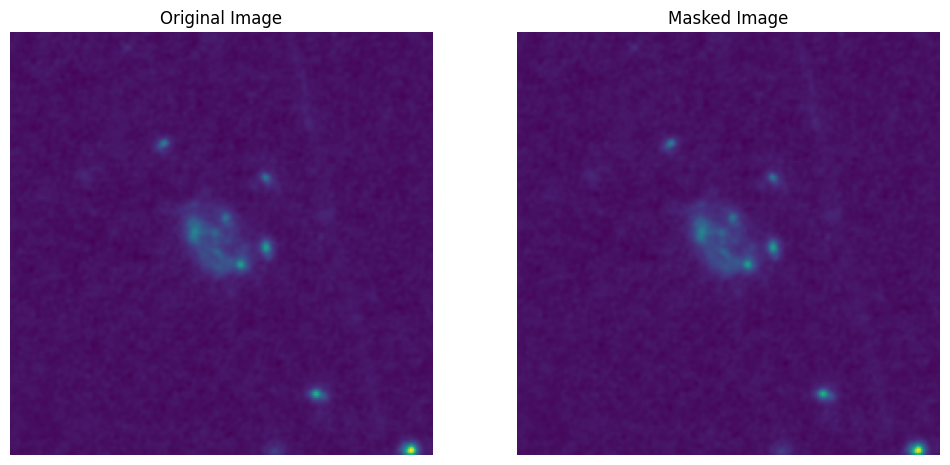

In [68]:
import matplotlib.pyplot as plt

# Placeholder for CANDELS_ID and clump ID
candels_id = '79'  # Replace 'x' with the actual CANDELS_ID of the galaxy
clump_id = '1'  # Replace 'y' with the actual Clump_ID

# Load the image data for the specific galaxy
image_data = load_image(candels_id, band)  # Ensure 'band' is defined correctly based on the galaxy's redshift

# Get the clump positions for this galaxy
clump_positions = [(x, y) for idx, (x, y) in enumerate(zip(goodss_result['X_clump'], goodss_result['Y_clump']))
                   if goodss_result['CANDELS_ID'][idx] == candels_id and idx != clump_id]

# Apply the mask to the image data
masked_image = apply_mask(image_data, clump_positions, clump_id, mask_radius=3)

# Now let's visualize the original and masked images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax1.imshow(image_data)
ax1.set_title('Original Image')
ax1.axis('off')

# Masked image
ax2.imshow(masked_image)
ax2.set_title('Masked Image')
ax2.axis('off')

plt.show()
